In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go
from plotly.subplots import make_subplots

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

# gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
# tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# nomes = [
#     "WENO-JS"     , "WENO-Z"      , "WENO-Z+"     , 
#     "WENO-JS (M)" , "WENO-Z (M)"  , "WENO-Z+ (M)" , 
#     "WENO-JS (MS)", "WENO-Z (MS)" , "WENO-Z+ (MS)", 
#     "WENO-JS (BI)", "WENO-Z (BI)" , "WENO-Z+ (BI)",
#     "WENO-ZC (M)" , "WENO-ZC (MS)", "WENO-ZC (BI)",
#     "Linear"
# ]

# API      = API_Numpy
# equation = transp_equation

# WENOs = {}
# WENOs[nomes[ 0]] = simulation(API, equation, WENO_JS, mapping =     null_mapping, map_function = None).Sim
# WENOs[nomes[ 1]] = simulation(API, equation, WENO_Z , mapping =     null_mapping, map_function = None).Sim
# WENOs[nomes[ 2]] = simulation(API, equation, WENO_Zp, mapping =     null_mapping, map_function = None).Sim
# WENOs[nomes[ 3]] = simulation(API, equation, WENO_JS, mapping =     post_mapping, map_function = Henrick_mapping).Sim
# WENOs[nomes[ 4]] = simulation(API, equation, WENO_Z , mapping =     post_mapping, map_function = Henrick_mapping).Sim
# WENOs[nomes[ 5]] = simulation(API, equation, WENO_Zp, mapping =     post_mapping, map_function = Henrick_mapping).Sim
# WENOs[nomes[ 6]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = Hong_mapping).Sim
# WENOs[nomes[ 7]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = Hong_mapping).Sim
# WENOs[nomes[ 8]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = Hong_mapping).Sim
# WENOs[nomes[ 9]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = BI_mapping).Sim
# WENOs[nomes[10]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = BI_mapping).Sim
# WENOs[nomes[11]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = BI_mapping).Sim
# WENOs[nomes[12]] = simulation(API, equation, WENO_ZC, mapping = post_inv_mapping, map_function = Henrick_mapping).Sim
# WENOs[nomes[13]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = Hong_mapping).Sim
# WENOs[nomes[14]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = BI_mapping).Sim

# WENOs[nomes[15]] = simulation(API, equation, WENO_linear, mapping = null_mapping, map_function = None).Sim
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
nomes = ["WENO-Z", "WENO-Z+", "WENO-ZD+", "WENO-ZD", "WENO-D", "WENO-JS"]

cores = {}
cores[nomes[0]] = "#4262C1" # WENO-Z   : Azul
cores[nomes[1]] = "#C23C52" # WENO-Z+  : Vermelho
cores[nomes[2]] = "#57933B" # WENO-ZD+ : Verde
cores[nomes[3]] = "#C2881D" # WENO-ZD  : Dourado
cores[nomes[4]] = "#A23CB1" # WENO-D   : Roxo
cores[nomes[5]] = "#72C5D6" # WENO-JS  : Ciano

API      = API_Numpy
equation = transp_equation
γ        = 1.4

WENOs = {}
WENOs[nomes[0]] = simulation(API, equation, WENO_Z_scheme    , γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim
WENOs[nomes[1]] = simulation(API, equation, WENO_Zp_scheme   , γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim
WENOs[nomes[2]] = simulation(API, equation, WENO_ZDp_4_scheme, γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim
WENOs[nomes[3]] = simulation(API, equation, WENO_ZD_2_scheme , γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim
WENOs[nomes[4]] = simulation(API, equation, WENO_D_scheme    , γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim
WENOs[nomes[5]] = simulation(API, equation, WENO_JS_scheme   , γ, mapping=null_mapping, map_function=lambda x:x, network=None, p=2, ε=ε_default).Sim

nomes = ["WENO-Z", "WENO-Z+", "WENO-ZD", "WENO-ZD+"]
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------


In [3]:
def teste_ADR(N, phi):
    
    f = lambda x, phi: np.exp(1j*x*phi)
    x = np.arange(N, dtype = dtype)
    
    return f(x, phi)

In [4]:
# Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

# def f_test(x):
#     z = tf.constant(-0.7, dtype=float_pres)
#     δ = tf.constant(0.005, dtype=float_pres)
#     β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
#     a = tf.constant(0.5, dtype=float_pres)
#     α = tf.constant(10, dtype=float_pres)
    
#     def G(x, β, z):
#         return tf.math.exp(-β*(x-z)**2)
    
#     def F(x, α, a):
#         return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
#     f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
#     f2 = 1                                              # x in [-0.4, -0.2]
#     f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
#     f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
#     f5 = 0.1                                            # otherwise
    
#     condition = tf.math.logical_and(
#         tf.math.greater_equal(x, -0.8),
#         tf.math.less_equal(x, -0.6)
#     )
#     f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
#     condition = tf.math.logical_and(
#         tf.math.greater_equal(x, -0.4),
#         tf.math.less_equal(x, -0.2)
#     )
#     f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
#     condition = tf.math.logical_and(
#         tf.math.greater_equal(x, 0.0),
#         tf.math.less_equal(x, 0.2)
#     )
#     f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
#     condition = tf.math.logical_and(
#         tf.math.greater_equal(x, 0.4),
#         tf.math.less_equal(x, 0.6)
#     )
#     f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
#     f = f1 + f2 + f3 + f4 + f5
    
#     return f

# plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [5]:
N   = 100 #400
Δx  = 1/N
τ   = 10**(-10)
CFL = 0.5

fronteira = FronteiraPeriodica

# formas = np.asarray(f_test(np.arange(-1, 1, 2/N))).astype("complex64")
# formas = formas

ADR  = {}
wave = {}
for nome in nomes:
    
    Phi = np.zeros(int(N/2)+1, dtype="complex64")
    for n in np.arange(int(N/2)+1):
        
        phi    = 2*np.pi*n/N
        u      = teste_ADR(N, phi) #*formas
        u_hat  = WENOs[nome](u, τ, Δx, CFL, fronteira)
        v      = np.exp(-1j*np.arange(N)*phi) #/formas
        v      = np.matmul(u_hat, v)/N
        
        Phi[n] = 1j*(Δx/τ)*np.log(v)

    ADR[nome]  = Phi
    wave[nome] = u_hat
    print(nome)

WENO-Z
WENO-Z+
WENO-ZD
WENO-ZD+


In [ ]:
# Caso linear analítico

# x_linear = 2*np.pi*np.arange(int(N/2)+1)/N
# y_linear = np.zeros([len(x_linear)], dtype="complex64")
# for i in np.arange(len(y_linear)):
#     y_linear[i] = -1j*np.dot(np.asarray([-1, 9, -45, 0, 45, -9, 1]), np.exp(1j*np.asarray([-3, -2, -1, 0, 1, 2, 3])*x_linear[i]))/60
    

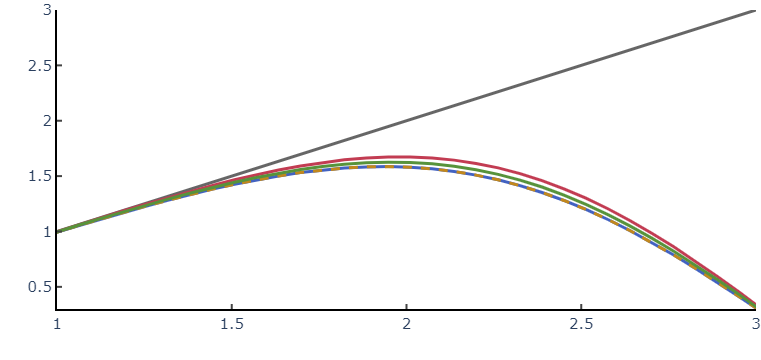

In [14]:
# Para os métodos WENO-Z, WENO-Z+, WENO-ZD, WENO-ZD+
line_type = {}
line_type[nomes[0]] = None
line_type[nomes[1]] = None
line_type[nomes[2]] = "dash"
line_type[nomes[3]] = None

fig = make_subplots(
    rows  = 1, 
    cols  = 1
)

fig.add_trace(
    ply_go.Scatter(
        x     = 2*np.pi*np.arange(int(N/2)+1)/N                  ,
        y     = 2*np.pi*np.arange(int(N/2)+1)/N                  ,
        mode  = "lines"                                          ,
        line  = ply_go.scatter.Line(color = "#666666", width = 3),
        name  = "Reference"                                      ,
        xaxis = "x"                                              ,
        yaxis = "y"                                              ,
        legendgroup = "Reference",
        showlegend  = False
    ),
    row = 1,
    col = 1
)

for nome in nomes:
    
    x = 2*np.pi*np.arange(int(N/2)+1)/N 
    y = np.real(ADR[nome])
    
    fig.add_trace(
        ply_go.Scatter(
            x          = x       ,
            y          = y       ,
            mode       = "lines" ,
            name       = nome    ,
            line = ply_go.scatter.Line(
                color = cores[nome],
                width = 3          ,
                dash  = line_type[nome]
            ),
            xaxis = "x" ,
            yaxis = "y" ,
            legendgroup = nome,
            showlegend  = False
        ),
        row = 1,
        col = 1
    )
    
fig.update_layout(
        paper_bgcolor = "#FFFFFF",
        plot_bgcolor  = "#FFFFFF",
        font_size     = 15       ,
        xaxis         = dict(
            linecolor = "#000000" , 
            ticks     = "inside"  ,
            tickwidth = 2         ,
            title     = ""       ,
            linewidth = 2         ,
            tickfont_size = 15    ,
            range     = [1, 3]
        ),
        yaxis         = dict(
            linecolor = "#000000" ,
            ticks     = "inside"  ,
            tickwidth = 2         ,
            title     = ""        ,
            linewidth = 2         ,
            tickfont_size = 15    ,
            range     = [0.3, 3]
        ),
        legend = dict(
            x             = 0.01      ,
            y             = 0.99      ,
            xanchor       = "left"    ,
            yanchor       = "top"     ,
            title         = ""        ,
            bordercolor   = "#666666" ,
            borderwidth   = 2         ,
            itemwidth     = 30        ,
            itemsizing    = "trace"   ,
            tracegroupgap = 0
        ),
        margin = ply_go.layout.Margin(
            l = 0  , #left margin
            r = 0  , #right margin
            b = 10 , #bottom margin
            t = 10   #top margin
        )
    )

fig.show()
# fig.write_html("htmls/teste ADR real (N=100, tau=10^(-10)).html")
# fig.write_image("htmls/teste ADR real (N=100, tau=10^(-10)).pdf", width = 480, height = 340)

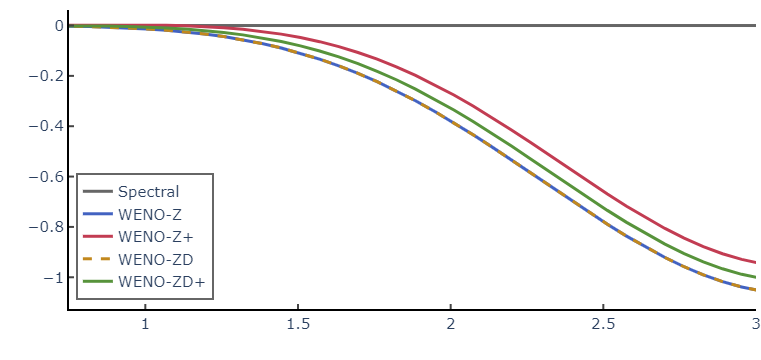

In [20]:
fig = make_subplots(
    rows  = 1, 
    cols  = 1
)

fig.add_trace(
    ply_go.Scatter(
        x     = 2*np.pi*np.arange(int(N/2)+1)/N                  ,
        y     = 0*np.arange(int(N/2)+1)                          ,
        mode  = "lines"                                          ,
        line  = ply_go.scatter.Line(color = "#666666", width = 3),
        name  = "Spectral"                                      ,
        xaxis = "x"                                              ,
        yaxis = "y"                                              ,
        legendgroup = "Spectral",
        showlegend  = True
    ),
    row = 1,
    col = 1
)

for nome in nomes:
    
    x = 2*np.pi*np.arange(int(N/2)+1)/N 
    y = np.imag(ADR[nome])
    
    fig.add_trace(
        ply_go.Scatter(
            x          = x       ,
            y          = y       ,
            mode       = "lines" ,
            name       = nome    ,
            line = ply_go.scatter.Line(
                color = cores[nome],
                width = 3          ,
                dash  = line_type[nome]
            ),
            xaxis = "x" ,
            yaxis = "y" ,
            legendgroup = nome,
            showlegend  = True
        ),
        row = 1,
        col = 1
    )
    
fig.update_layout(
        paper_bgcolor = "#FFFFFF",
        plot_bgcolor  = "#FFFFFF",
        font_size     = 15       ,
        xaxis         = dict(
            linecolor = "#000000" , 
            ticks     = "inside"  ,
            tickwidth = 2         ,
            title     = ""        ,
            linewidth = 2         ,
            tickfont_size = 15    ,
            range     = [0.75, 3]
        ),
        yaxis         = dict(
            linecolor = "#000000" ,
            ticks     = "inside"  ,
            tickwidth = 2         ,
            title     = ""        ,
            linewidth = 2         ,
            tickfont_size = 15    ,
            range     = None
        ),
        legend = dict(
            x             = 0.01      ,
            y             = 0.03      ,
            xanchor       = "left"    ,
            yanchor       = "bottom"  ,
            title         = ""        ,
            bordercolor   = "#666666" ,
            borderwidth   = 2         ,
            itemwidth     = 30        ,
            itemsizing    = "trace"   ,
            tracegroupgap = 0
        ),
        margin = ply_go.layout.Margin(
            l = 0  , #left margin
            r = 0  , #right margin
            b = 10 , #bottom margin
            t = 10   #top margin
        )
    )
fig.update_yaxes(exponentformat="power")

# Zoom out
# x_range = [0.75, 3]
# y_range = None

# Defeito WENO-Z+
# x_range = [0.2, 1.3]
# y_range = [-0.003, 0.003]

# Defeito WENO-ZD+
# x_range = [0.1, 0.7]
# y_range = [-0.00002, 0.00002]

fig.show()
# fig.write_html("teste ADR imag (N=100, tau=10^(-10)).html")
# fig.write_image("htmls/teste ADR imag (N=100, tau=10^(-10)).pdf", width = 480, height = 340)
# fig.write_image("htmls/teste ADR imag defeito WENO-Z+ (N=100, tau=10^(-10)).pdf", width = 480, height = 340)